# Train a Model via API

This notebook demonstrates how to train, test and infer the EfficientAD model via Anomalib API. Compared to the CLI entrypoints such as \`tools/\<train, test, inference>.py, the API offers more flexibility such as modifying the existing model or designing custom approaches.

## Setting up the Dataset Directory

This cell is to ensure we change the directory to have access to the datasets.


In [1]:
# NOTE: Provide the path to the dataset root directory.
#   If the datasets is not downloaded, it will be downloaded
#   to this directory.
dataset_root = "/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Dataset"

## Imports


In [2]:
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display
import torch
from pathlib import Path

from anomalib.data import PredictDataset, Folder
from anomalib.engine import Engine
from anomalib.models import Dfm
from anomalib import TaskType
from anomalib.loggers import AnomalibTensorBoardLogger
from anomalib.data.utils import read_image
from anomalib.deploy import OpenVINOInferencer
from anomalib.utils.normalization import NormalizationMethod
import os, pprint, yaml, warnings, math, glob, cv2, random, logging
%matplotlib inline
torch.cuda.empty_cache()

## Data Module

To train the model end-to-end, we do need to have a dataset. In our [previous notebooks](https://github.com/openvinotoolkit/anomalib/tree/main/notebooks/100_datamodules), we demonstrate how to initialize benchmark- and custom datasets. In this tutorial, we will use MVTec AD DataModule. We assume that `datasets` directory is created in the `anomalib` root directory and `MVTec` dataset is located in `datasets` directory.

Before creating the dataset, let's define the task type that we will be working on. In this notebook, we will be working on a segmentation task. Therefore the `task` variable would be:


In [3]:
task = TaskType.CLASSIFICATION

In [4]:
datamodule = Folder(
    #root="/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Dataset",
    name="",
    root=dataset_root,
    normal_dir="train/FC",
    abnormal_dir="train/NG",
    normal_test_dir="val/FC",
    normal_split_ratio=0.0,
    image_size=(256, 256),
    train_batch_size=32,
    eval_batch_size=32,
    num_workers=4,
    task=task,
)

datamodule.setup()
datamodule.prepare_data()

i, data = next(enumerate(datamodule.test_dataloader()))
print(data["image"].shape)

torch.Size([32, 3, 256, 256])


In [5]:
len(datamodule.train_dataloader())

93

## DFM Model

Now that we have created the Folder datamodule, we could create the DFM model. We could start with printing its docstring.


In [6]:
#Dfm??

In [7]:
import timm
print(timm.list_models('*densenet*'))
print(timm.list_models('*resnet*'))

['densenet121', 'densenet161', 'densenet169', 'densenet201', 'densenet264d', 'densenetblur121d']
['cspresnet50', 'cspresnet50d', 'cspresnet50w', 'eca_resnet33ts', 'ecaresnet26t', 'ecaresnet50d', 'ecaresnet50d_pruned', 'ecaresnet50t', 'ecaresnet101d', 'ecaresnet101d_pruned', 'ecaresnet200d', 'ecaresnet269d', 'ecaresnetlight', 'gcresnet33ts', 'gcresnet50t', 'inception_resnet_v2', 'lambda_resnet26rpt_256', 'lambda_resnet26t', 'lambda_resnet50ts', 'legacy_seresnet18', 'legacy_seresnet34', 'legacy_seresnet50', 'legacy_seresnet101', 'legacy_seresnet152', 'nf_ecaresnet26', 'nf_ecaresnet50', 'nf_ecaresnet101', 'nf_resnet26', 'nf_resnet50', 'nf_resnet101', 'nf_seresnet26', 'nf_seresnet50', 'nf_seresnet101', 'resnet10t', 'resnet14t', 'resnet18', 'resnet18d', 'resnet26', 'resnet26d', 'resnet26t', 'resnet32ts', 'resnet33ts', 'resnet34', 'resnet34d', 'resnet50', 'resnet50_gn', 'resnet50c', 'resnet50d', 'resnet50s', 'resnet50t', 'resnet51q', 'resnet61q', 'resnet101', 'resnet101c', 'resnet101d', 'res

In [14]:
#densenet121,169 Available layers: ['features.norm0', 'features.denseblock1', 'features.denseblock2', 'features.denseblock3', 'features.norm5']

model = Dfm(
    backbone="densenet201",
    layer="features.denseblock3",
    pre_trained=True,
    pooling_kernel_size=4,
    pca_level=0.97,
    score_type="fre"
)

## Training

Now that we set up the datamodule, model, optimizer and the callbacks, we could now train the model.

The final component to train the model is `Engine` object, which handles train/test/predict pipeline. Let's create the engine object to train the model.


In [15]:
logger = AnomalibTensorBoardLogger("tb_logs", name="DFM_logs")

engine = Engine(
    normalization=NormalizationMethod.MIN_MAX,
    threshold="F1AdaptiveThreshold",
    image_metrics = ["F1Score", "AUROC", "Precision", "Recall"],
    accelerator="gpu",  # \<"cpu", "gpu", "tpu", "ipu", "hpu", "auto">,
    devices="auto",
    task=TaskType.CLASSIFICATION,
    logger=logger
)

`Trainer` object has number of options that suit all specific needs. For more details, refer to [Lightning Documentation](https://pytorch-lightning.readthedocs.io/en/stable/common/engine.html) to see how it could be tweaked to your needs.

Let's train the model now.


In [16]:
import os

# Your original path
original_path = "~/cloudfiles/code/Users/rohit.potdukhe/Dataset/v1.0.0/train"

# Expand the tilde to the full home directory path
expanded_path = os.path.expanduser(original_path)

print(expanded_path)  # This should print the correct path

/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Dataset/v1.0.0/train


In [17]:
engine.fit(datamodule=datamodule, model=model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
No implementation of `configure_transforms` was provided in the Lightning model. Using default transforms from the base class. This may not be suitable for your use case. Please override `configure_transforms` in your model.
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
Incorrect constructor arguments for Precision metric from TorchMetrics package.
Incorrect constructor arguments for Recall metric from TorchMetrics package.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type                     | Params
-------------------------------------------------------------------
0 | model                 | DFMModel                 | 9.5 M 
1 | _transform            | Compose                  | 0     
2 | normalization_metrics | MinMax      

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


## Test

In [43]:
"""model = Dfm(
    backbone="resnet50",
    layer="layer4",
    pre_trained=True,
    pooling_kernel_size=4,
    pca_level=0.97,
    score_type="nll"
)"""
engine.test(datamodule=datamodule, model=model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.6309624910354614     │
│       image_F1Score       │    0.8366846442222595     │
└───────────────────────────┴───────────────────────────┘

[{'image_F1Score': 0.8366846442222595, 'image_AUROC': 0.6309624910354614}]

In [85]:
"""model = Dfm(
    backbone="wide_resnet50_2",
    layer="layer2",
    pre_trained=True,
    pooling_kernel_size=4,
    pca_level=0.97,
    score_type="nll"
)"""
engine.test(datamodule=datamodule, model=model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.6382127404212952     │
│       image_F1Score       │    0.8352078199386597     │
└───────────────────────────┴───────────────────────────┘

[{'image_F1Score': 0.8352078199386597, 'image_AUROC': 0.6382127404212952}]

In [11]:
"""
model = Dfm(
    backbone="wide_resnet50_2",
    layer="layer3",
    pre_trained=True,
    pooling_kernel_size=4,
    pca_level=0.97,
    score_type="nll"
)
"""
engine.test(datamodule=datamodule, model=model)

F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
Incorrect constructor arguments for Precision metric from TorchMetrics package.
Incorrect constructor arguments for Recall metric from TorchMetrics package.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │     0.68155837059021      │
│       image_F1Score       │    0.8355295062065125     │
└───────────────────────────┴───────────────────────────┘

[{'image_F1Score': 0.8355295062065125, 'image_AUROC': 0.68155837059021}]

In [29]:
"""
model = Dfm(
    backbone="wide_resnet50_2",
    layer="layer3",
    pre_trained=True,
    pooling_kernel_size=4,
    pca_level=0.97,
    score_type="fre"
)
"""
engine.test(datamodule=datamodule, model=model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.6496402025222778     │
│       image_F1Score       │    0.8484848737716675     │
└───────────────────────────┴───────────────────────────┘

[{'image_F1Score': 0.8484848737716675, 'image_AUROC': 0.6496402025222778}]

In [66]:
"""
model = Dfm(
    backbone="wide_resnet50_2",
    layer="layer2",
    pre_trained=True,
    pooling_kernel_size=4,
    pca_level=0.995,
    score_type="fre"
)
"""
engine.test(datamodule=datamodule, model=model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.5794808864593506     │
│       image_F1Score       │    0.8413654565811157     │
└───────────────────────────┴───────────────────────────┘

[{'image_F1Score': 0.8413654565811157, 'image_AUROC': 0.5794808864593506}]

In [88]:
"""
model = Dfm(
    backbone="densenet121",
    layer="features.norm5",
    pre_trained=True,
    pooling_kernel_size=4,
    pca_level=0.97,
    score_type="fre"
)
"""
engine.test(datamodule=datamodule, model=model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.7309548854827881     │
│       image_F1Score       │    0.8457968235015869     │
└───────────────────────────┴───────────────────────────┘

[{'image_F1Score': 0.8457968235015869, 'image_AUROC': 0.7309548854827881}]

In [13]:
"""model = Dfm(
    backbone="densenet169",
    layer="features.norm5",
    pre_trained=True,
    pooling_kernel_size=4,
    pca_level=0.97,
    score_type="fre"
)"""

engine.test(datamodule=datamodule, model=model)

F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
Incorrect constructor arguments for Precision metric from TorchMetrics package.
Incorrect constructor arguments for Recall metric from TorchMetrics package.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.7456321120262146     │
│       image_F1Score       │    0.8485164046287537     │
└───────────────────────────┴───────────────────────────┘

[{'image_F1Score': 0.8485164046287537, 'image_AUROC': 0.7456321120262146}]

In [38]:
"""model = Dfm(
    backbone="densenet169",
    layer="features.denseblock3",
    pre_trained=True,
    pooling_kernel_size=4,
    pca_level=0.97,
    score_type="fre"
)"""

engine.test(datamodule=datamodule, model=model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.7203333377838135     │
│       image_F1Score       │    0.8472906351089478     │
└───────────────────────────┴───────────────────────────┘

[{'image_F1Score': 0.8472906351089478, 'image_AUROC': 0.7203333377838135}]

In [12]:
"""model = Dfm(
    backbone="densenet169",
    layer="features.denseblock3",
    pre_trained=True,
    pooling_kernel_size=4,
    pca_level=0.995,
    score_type="fre"
)"""

engine.test(datamodule=datamodule, model=model)

F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
Incorrect constructor arguments for Precision metric from TorchMetrics package.
Incorrect constructor arguments for Recall metric from TorchMetrics package.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.7189900875091553     │
│       image_F1Score       │    0.8454935550689697     │
└───────────────────────────┴───────────────────────────┘

[{'image_F1Score': 0.8454935550689697, 'image_AUROC': 0.7189900875091553}]

In [30]:
"""model = Dfm(
    backbone="densenet201",
    layer="features.denseblock3",
    pre_trained=True,
    pooling_kernel_size=4,
    pca_level=0.995,
    score_type="fre"
)"""

engine.test(datamodule=datamodule, model=model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.7258746027946472     │
│       image_F1Score       │    0.8462774753570557     │
└───────────────────────────┴───────────────────────────┘

[{'image_F1Score': 0.8462774753570557, 'image_AUROC': 0.7258746027946472}]

In [49]:
"""model = Dfm(
    backbone="densenet264d",
    layer="features.denseblock3",
    pre_trained=False,
    pooling_kernel_size=4,
    pca_level=0.995,
    score_type="fre"
)"""

engine.test(datamodule=datamodule, model=model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.8028924465179443     │
│       image_F1Score       │    0.8471096754074097     │
└───────────────────────────┴───────────────────────────┘

[{'image_F1Score': 0.8471096754074097, 'image_AUROC': 0.8028924465179443}]

In [18]:
"""model = Dfm(
    backbone="densenet201",
    layer="features.denseblock3",
    pre_trained=True,
    pooling_kernel_size=4,
    pca_level=0.97,
    score_type="fre"
)"""

engine.test(datamodule=datamodule, model=model)

F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
Incorrect constructor arguments for Precision metric from TorchMetrics package.
Incorrect constructor arguments for Recall metric from TorchMetrics package.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.7265176177024841     │
│       image_F1Score       │    0.8459892868995667     │
└───────────────────────────┴───────────────────────────┘

[{'image_F1Score': 0.8459892868995667, 'image_AUROC': 0.7265176177024841}]

## Export

In [25]:
!zip -r tb_logs_DFM.zip tb_logs

  adding: tb_logs/ (stored 0%)
  adding: tb_logs/DFKDE_Resnet18_logs/ (stored 0%)
  adding: tb_logs/DFKDE_Resnet18_logs/version_0/ (stored 0%)
  adding: tb_logs/DFKDE_Resnet18_logs/version_0/events.out.tfevents.1716028111.rohit-unite-13th-may.9220.0 (deflated 31%)
  adding: tb_logs/DFKDE_Resnet18_logs/version_0/events.out.tfevents.1716028249.rohit-unite-13th-may.9220.1 (deflated 3%)
  adding: tb_logs/DFKDE_Resnet18_logs/version_0/hparams.yaml (deflated 14%)
  adding: tb_logs/DFKDE_Resnet18_logs/version_1/ (stored 0%)
  adding: tb_logs/DFKDE_Resnet18_logs/version_1/events.out.tfevents.1716029016.rohit-unite-13th-may.9220.2 (deflated 32%)
  adding: tb_logs/DFKDE_Resnet18_logs/version_1/events.out.tfevents.1716029072.rohit-unite-13th-may.9220.3 (deflated 3%)
  adding: tb_logs/DFKDE_Resnet18_logs/version_1/hparams.yaml (deflated 12%)
  adding: tb_logs/DFKDE_Resnet18_logs_layer1,2,3/ (stored 0%)
  adding: tb_logs/DFKDE_Resnet18_logs_layer1,2,3/version_0/ (stored 0%)
  adding: tb_logs/DFKDE_

In [19]:
from anomalib.deploy import ExportType

export_root = Path.cwd() / 'weights' / 'DFM'

export_root.mkdir(parents=True, exist_ok=True)

# Exporting model to OpenVINO
openvino_model_path = engine.export(
    model=model,
    export_type=ExportType.OPENVINO,
    export_root=str(export_root),
)

/mnt/batch/tasks/shared/LS_root/mounts/clusters/rohit-unite-13th-may/code/Users/rohit.potdukhe/Unite/anomalib/src/anomalib/models/image/dfm/torch_model.py:160: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  batch_size = len(features)


## Inference

Since we have a trained model, we could infer the model on an individual image or folder of images. Anomalib has an `PredictDataset` to let you create an inference dataset. So let's try it.


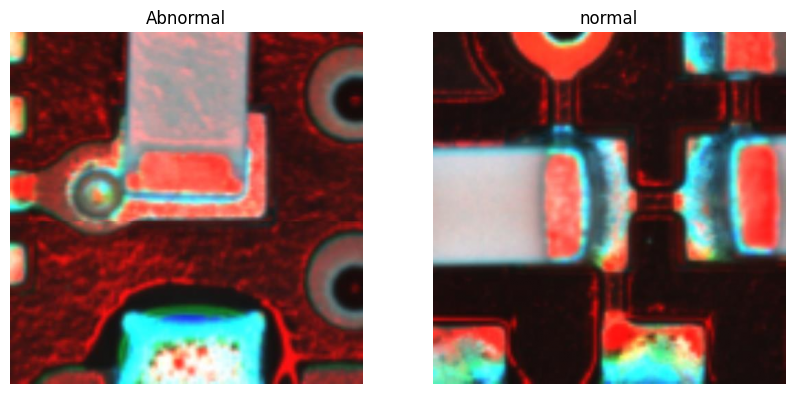

In [20]:
%matplotlib inline

image_normal = read_image(path="/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Dataset/pred_test/FC/Package102_BF1911027564_102_2_7_7_Multi.jpg")
image_abnormal = read_image(path="/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Dataset/pred_test/NG/Package102_BF2001009461_602_8_6_6_Multi.jpg")


# Plot the images side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_abnormal)
plt.axis('off')  
plt.title("Abnormal")

plt.subplot(1, 2, 2)
plt.imshow(image_normal)
plt.axis('off')  
plt.title("normal")

plt.show()

## Visualization


In [21]:
metadata_path = openvino_model_path.parent / "metadata.json"
print(openvino_model_path.exists(), metadata_path.exists())

True True


In [22]:
inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata_path,  # Path to the metadata file.
    device="CPU",  
)

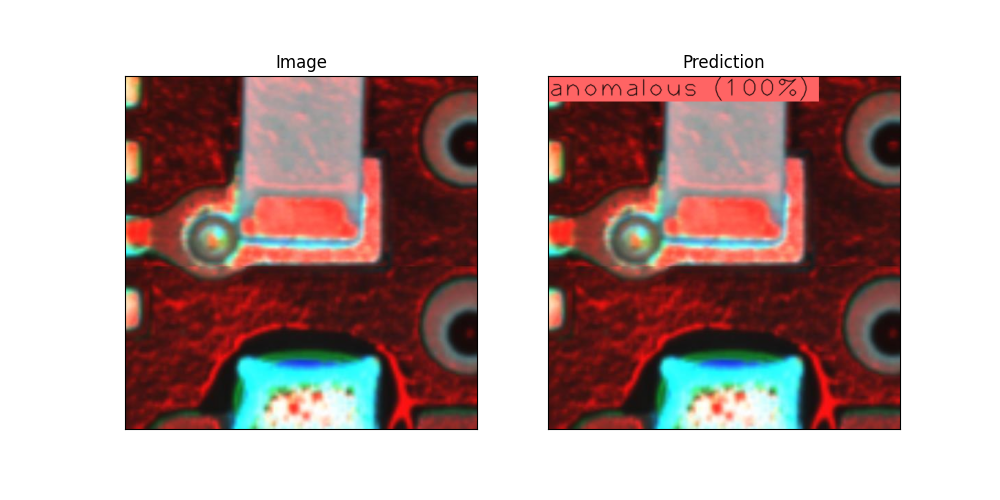

In [23]:
from anomalib.utils.visualization.image import ImageVisualizer, VisualizationMode
from PIL import Image

predictions = inferencer.predict(image=image_abnormal)
visualizer = ImageVisualizer(mode=VisualizationMode.FULL, task=task)
output_image = visualizer.visualize_image(predictions)
Image.fromarray(output_image)

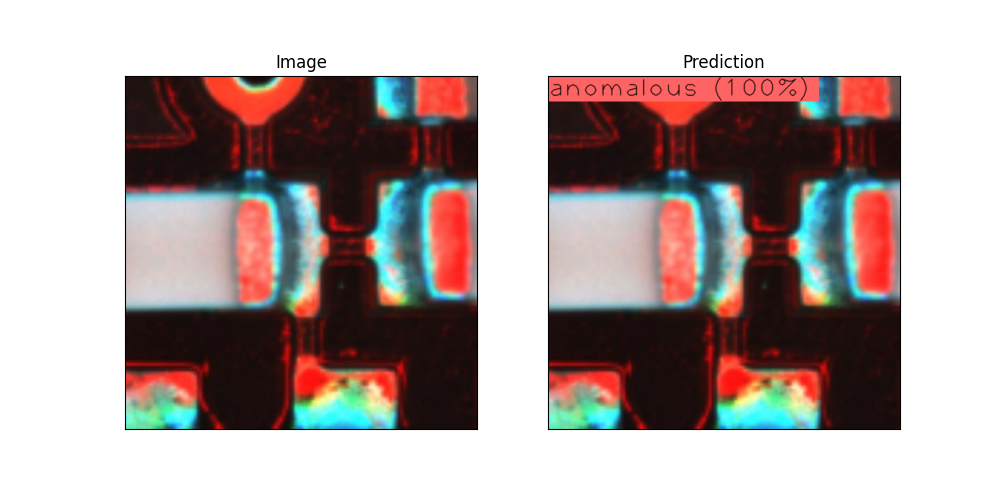

In [24]:
predictions = inferencer.predict(image=image_normal)
visualizer = ImageVisualizer(mode=VisualizationMode.FULL, task=task)
output_image = visualizer.visualize_image(predictions)
Image.fromarray(output_image)

## prediction  on all images

In [25]:
def inference(dataset_path, label):
    predictions = []

    image_paths = list(dataset_path.glob("**/*.jpg"))

    for image_path in image_paths:
        image = read_image(image_path)

        prediction = inferencer.predict(image=image)
        predictions.append((image_path, prediction, label))
    
    return predictions


In [26]:
def process_all_predictions(normal_predictions, abnormal_predictions):
    all_predictions = []
    all_labels = []
    misclassified_files = []

    # Process normal predictions
    for file_path, image_result, _ in normal_predictions:
        pred_label = 1 if image_result.pred_label else 0
        all_predictions.append(pred_label)
        all_labels.append(0)  # 0 for normal
        if pred_label != 0:
            misclassified_files.append((file_path, 'Normal', 'Predicted as Abnormal'))

    # Process abnormal predictions
    for file_path, image_result, _ in abnormal_predictions:
        pred_label = 1 if image_result.pred_label else 0
        all_predictions.append(pred_label)
        all_labels.append(1)  # 1 for abnormal
        if pred_label != 1:
            misclassified_files.append((file_path, 'Abnormal', 'Predicted as Normal'))
        
    return all_predictions, all_labels, misclassified_files

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(y_true, y_pred, classes):

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    # Create a heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.show()

## Inference with

model = Dfm(
    backbone="resnet50",
    layer="layer4",
    pre_trained=True,
    pooling_kernel_size=4,
    pca_level=0.97,
    score_type="nll"
)

In [53]:
inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata_path,  # Path to the metadata file.
    device="CPU",  
)

normal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Dataset/pred_test/FC")
abnormal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Dataset/pred_test/NG")

normal_predictions = inference(normal_img_path, label = "normal")
abnormal_predictions = inference(abnormal_img_path, label = "abnormal")

In [54]:
all_predictions, all_labels, misclassified_files = process_all_predictions(normal_predictions, abnormal_predictions)

In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# Display the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.5071428571428571
Precision: 0.5035971223021583
Recall: 1.0
F1 Score: 0.6698564593301436


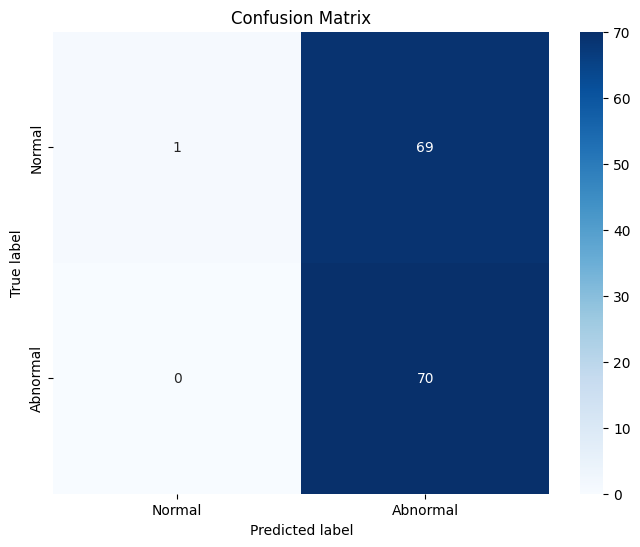

In [56]:
%matplotlib inline

class_names = ['Normal', 'Abnormal']
plot_confusion_matrix(all_labels, all_predictions, class_names)


## Inference with

model = Dfm(
    backbone="wide_resnet50_2",
    layer="layer2",
    pre_trained=True,
    pooling_kernel_size=4,
    pca_level=0.97,
    score_type="nll"
)

In [41]:
inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata_path,  # Path to the metadata file.
    device="CPU",  
)

normal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Dataset/pred_test/FC")
abnormal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Dataset/pred_test/NG")

normal_predictions = inference(normal_img_path, label = "normal")
abnormal_predictions = inference(abnormal_img_path, label = "abnormal")

In [42]:
all_predictions, all_labels, misclassified_files = process_all_predictions(normal_predictions, abnormal_predictions)

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# Display the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.6
Precision: 0.5555555555555556
Recall: 1.0
F1 Score: 0.7142857142857143


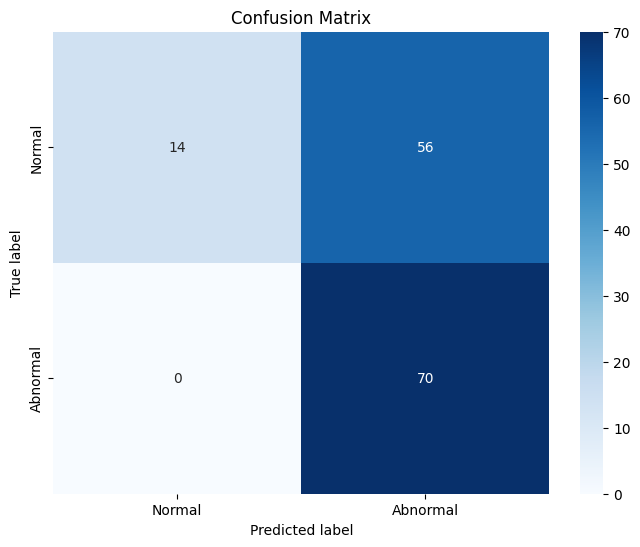

In [44]:
%matplotlib inline

class_names = ['Normal', 'Abnormal']
plot_confusion_matrix(all_labels, all_predictions, class_names)

## Inference with

model = Dfm(
    backbone="wide_resnet50_2",
    layer="layer3",
    pre_trained=True,
    pooling_kernel_size=4,
    pca_level=0.97,
    score_type="fre"
)

In [52]:
inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata_path,  # Path to the metadata file.
    device="CPU",  
)

normal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Dataset/pred_test/FC")
abnormal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Dataset/pred_test/NG")

normal_predictions = inference(normal_img_path, label = "normal")
abnormal_predictions = inference(abnormal_img_path, label = "abnormal")

In [53]:
all_predictions, all_labels, misclassified_files = process_all_predictions(normal_predictions, abnormal_predictions)

In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# Display the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.6285714285714286
Precision: 0.5737704918032787
Recall: 1.0
F1 Score: 0.7291666666666666


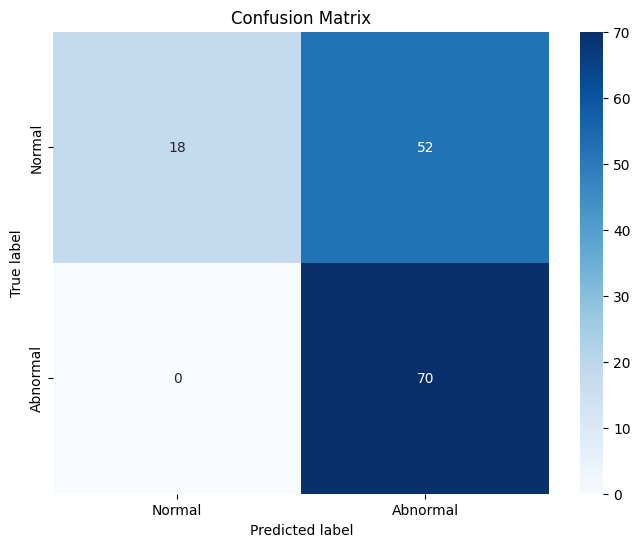

In [55]:
%matplotlib inline

class_names = ['Normal', 'Abnormal']
plot_confusion_matrix(all_labels, all_predictions, class_names)

## Inference with

model = Dfm(
    backbone="wide_resnet50_2",
    layer="layer2",
    pre_trained=True,
    pooling_kernel_size=4,
    pca_level=0.995,
    score_type="fre"
)

In [76]:
inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata_path,  # Path to the metadata file.
    device="CPU",  
)

normal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Dataset/pred_test/FC")
abnormal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Dataset/pred_test/NG")

normal_predictions = inference(normal_img_path, label = "normal")
abnormal_predictions = inference(abnormal_img_path, label = "abnormal")

In [77]:
all_predictions, all_labels, misclassified_files = process_all_predictions(normal_predictions, abnormal_predictions)

In [78]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# Display the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.6214285714285714
Precision: 0.5691056910569106
Recall: 1.0
F1 Score: 0.7253886010362695


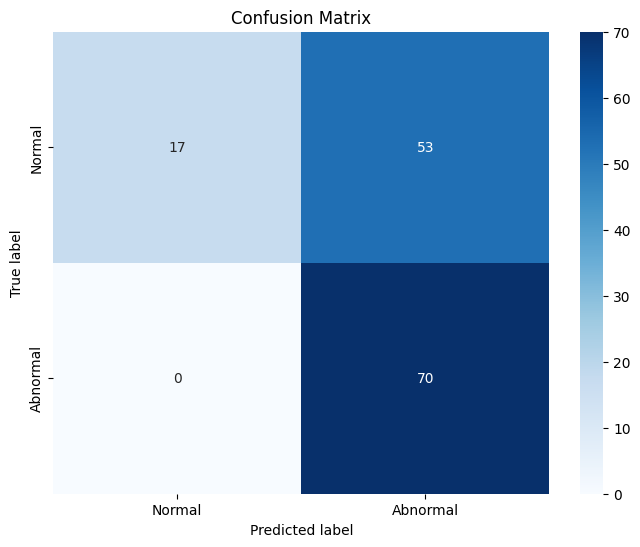

In [79]:
%matplotlib inline

class_names = ['Normal', 'Abnormal']
plot_confusion_matrix(all_labels, all_predictions, class_names)

## Inference with

model = Dfm(
    backbone="densenet121",
    layer="features.norm5",
    pre_trained=True,
    pooling_kernel_size=4,
    pca_level=0.97,
    score_type="fre"
)

In [98]:
inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata_path,  # Path to the metadata file.
    device="CPU",  
)

normal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Dataset/pred_test/FC")
abnormal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Dataset/pred_test/NG")

normal_predictions = inference(normal_img_path, label = "normal")
abnormal_predictions = inference(abnormal_img_path, label = "abnormal")

In [99]:
all_predictions, all_labels, misclassified_files = process_all_predictions(normal_predictions, abnormal_predictions)

In [100]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# Display the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.6142857142857143
Precision: 0.5645161290322581
Recall: 1.0
F1 Score: 0.7216494845360825


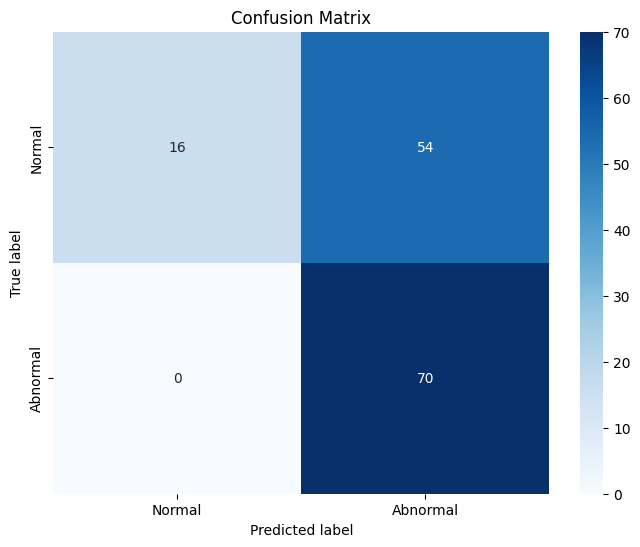

In [101]:
%matplotlib inline

class_names = ['Normal', 'Abnormal']
plot_confusion_matrix(all_labels, all_predictions, class_names)

## Inference with

model = Dfm(
    backbone="densenet169",
    layer="features.norm5",
    pre_trained=True,
    pooling_kernel_size=4,
    pca_level=0.97,
    score_type="fre"
)

In [23]:
inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata_path,  # Path to the metadata file.
    device="CPU",  
)

normal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Dataset/pred_test/FC")
abnormal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Dataset/pred_test/NG")

normal_predictions = inference(normal_img_path, label = "normal")
abnormal_predictions = inference(abnormal_img_path, label = "abnormal")

In [24]:
all_predictions, all_labels, misclassified_files = process_all_predictions(normal_predictions, abnormal_predictions)

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# Display the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.6571428571428571
Precision: 0.5932203389830508
Recall: 1.0
F1 Score: 0.7446808510638298


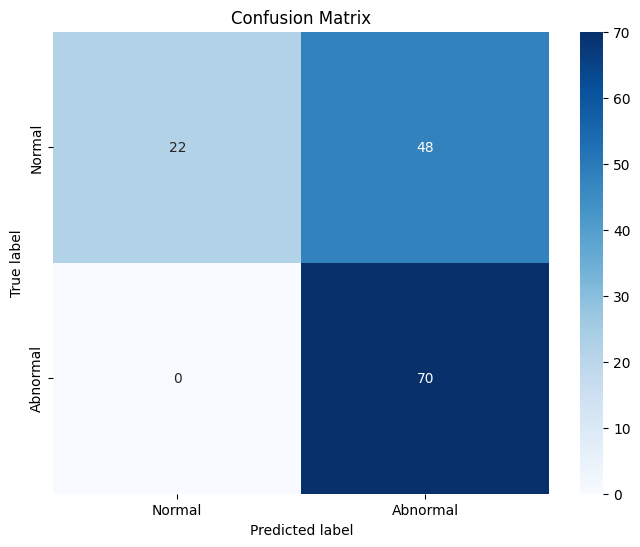

In [26]:
%matplotlib inline

class_names = ['Normal', 'Abnormal']
plot_confusion_matrix(all_labels, all_predictions, class_names)

## Inference with

model = Dfm(
    backbone="densenet169",
    layer="features.denseblock3",
    pre_trained=True,
    pooling_kernel_size=4,
    pca_level=0.97,
    score_type="fre"
)

In [48]:
inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata_path,  # Path to the metadata file.
    device="CPU",  
)

normal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Dataset/pred_test/FC")
abnormal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Dataset/pred_test/NG")

normal_predictions = inference(normal_img_path, label = "normal")
abnormal_predictions = inference(abnormal_img_path, label = "abnormal")

In [49]:
all_predictions, all_labels, misclassified_files = process_all_predictions(normal_predictions, abnormal_predictions)

In [50]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# Display the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.7285714285714285
Precision: 0.6538461538461539
Recall: 0.9714285714285714
F1 Score: 0.7816091954022989


Bad pipe message: %s [b'\x18{*']
Bad pipe message: %s [b'\xe3\\\x01E\x84D\xdf']
Bad pipe message: %s [b'\xb7\x08\x8e\x19\xd1\xd6\xacr\xd7 j+\x91\xdb\tS,z\x8e1\x03\x06\x7f\x95\x13\x01o\x9c\x7f3\xf7A\xb3\xdc0\x07\xc5k.\xb8-?\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00', b'\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08']
Bad pipe message: %s [b"\x06\xaa\x9e}\xfe\xd2w\x9aM\x84Q\x11\xe3\xdc\x91d\x7fQ\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00"]
Bad pipe message: %s [b

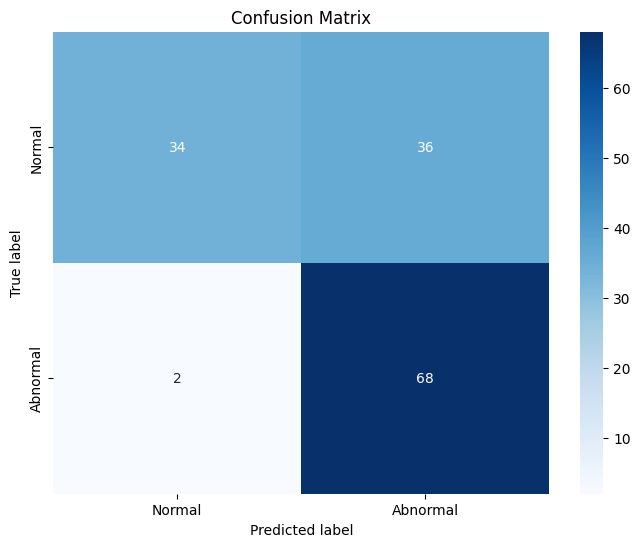

In [51]:
%matplotlib inline

class_names = ['Normal', 'Abnormal']
plot_confusion_matrix(all_labels, all_predictions, class_names)

## Inference with

model = Dfm(
    backbone="densenet201",
    layer="features.denseblock3",
    pre_trained=True,
    pooling_kernel_size=4,
    pca_level=0.995,
    score_type="fre"
)

In [28]:
inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata_path,  # Path to the metadata file.
    device="CPU",  
)

normal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Dataset/pred_test/FC")
abnormal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Dataset/pred_test/NG")

normal_predictions = inference(normal_img_path, label = "normal")
abnormal_predictions = inference(abnormal_img_path, label = "abnormal")

In [29]:
all_predictions, all_labels, misclassified_files = process_all_predictions(normal_predictions, abnormal_predictions)

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# Display the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.7214285714285714
Precision: 0.6422018348623854
Recall: 1.0
F1 Score: 0.7821229050279329


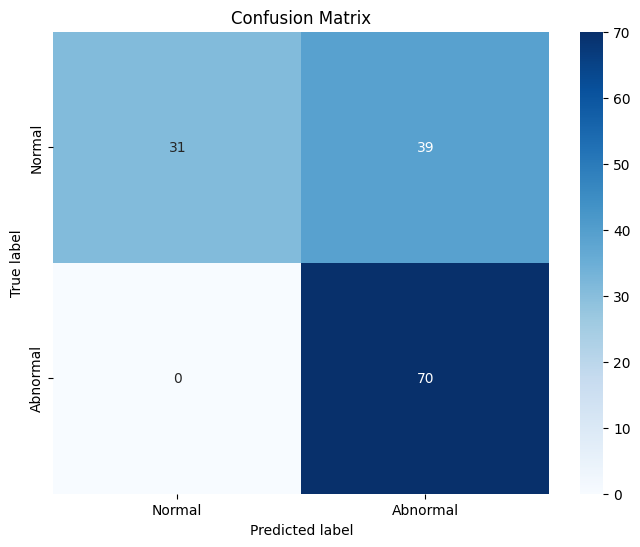

In [31]:
%matplotlib inline

class_names = ['Normal', 'Abnormal']
plot_confusion_matrix(all_labels, all_predictions, class_names)

## Inference with

model = Dfm(
    backbone="densenet201",
    layer="features.denseblock3",
    pre_trained=True,
    pooling_kernel_size=4,
    pca_level=0.97,
    score_type="fre"
)

In [40]:
inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata_path,  # Path to the metadata file.
    device="CPU",  
)

normal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Dataset/pred_test/FC")
abnormal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Dataset/pred_test/NG")

normal_predictions = inference(normal_img_path, label = "normal")
abnormal_predictions = inference(abnormal_img_path, label = "abnormal")

In [41]:
all_predictions, all_labels, misclassified_files = process_all_predictions(normal_predictions, abnormal_predictions)

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# Display the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.7142857142857143
Precision: 0.6388888888888888
Recall: 0.9857142857142858
F1 Score: 0.7752808988764045


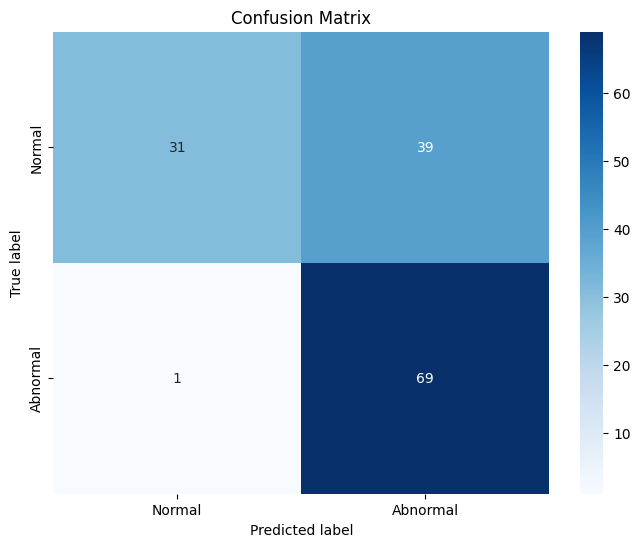

In [43]:
%matplotlib inline

class_names = ['Normal', 'Abnormal']
plot_confusion_matrix(all_labels, all_predictions, class_names)